In [1]:
!pip install geopandas
!pip install rioxarray

import numpy as np
import matplotlib.pyplot as plt
from math import *
import cv2
import geopandas as gpd
from google.colab import drive
import os
import pickle
import rioxarray
from pyproj import CRS
import fiona
from scipy.stats.stats import pearsonr
from matplotlib.collections import PatchCollection
import matplotlib
from sklearn.metrics import r2_score
import pandas as pd

drive.mount("/content/drive")
os.chdir('/content/drive/MyDrive/DREAMS - Zhiang/Projects/Rock Traits/data')
print(os.listdir())

     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 16.7 MB 260 kB/s 
     |████████████████████████████████| 6.3 MB 36.9 MB/s 
     |████████████████████████████████| 47 kB 2.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 19.3 MB 1.2 MB/s 
  Created wheel for rioxarray: filename=rioxarray-0.9.1-py3-none-any.whl size=54611 sha256=4a701860eea361b82fa5ea8cf44eac0cc5805ded2be03227f207387a22793c07
  Stored in directory: /root/.cache/pip/wheels/07/da/9e/1cc57b2e7a29a206893db83e984a341e2e94378263e0798229
Successfully built rioxarray
Mounted at /content/drive
['README', 'C3_sk.jpg', 'registered_instances_c3_rgbd1.pickle', 'registered_instances_c3_rgbd1_refined.pickle', 'registered_instances_c3_rgbd1_refined_update.pickle', 'c3_rocks', 'registered_instances_c3_rgbd1_update.pickle', 'registered_instances_c3_rgbd1_update_0.pic

In [2]:
from matplotlib.image import imread
from tempfile import NamedTemporaryFile

def get_size(fig, dpi=100):
    with NamedTemporaryFile(suffix='.png') as f:
        fig.savefig(f.name, bbox_inches='tight', dpi=dpi)
        height, width, _channels = imread(f.name).shape
        return width / dpi, height / dpi

def set_size(fig, size, dpi=100, eps=1e-2, give_up=2, min_size_px=10):
    target_width, target_height = size
    set_width, set_height = target_width, target_height # reasonable starting point
    deltas = [] # how far we have
    while True:
        fig.set_size_inches([set_width, set_height])
        actual_width, actual_height = get_size(fig, dpi=dpi)
        set_width *= target_width / actual_width
        set_height *= target_height / actual_height
        deltas.append(abs(actual_width - target_width) + abs(actual_height - target_height))
        if deltas[-1] < eps:
            return True
        if len(deltas) > give_up and sorted(deltas[-give_up:]) == deltas[-give_up:]:
            return False
        if set_width * dpi < min_size_px or set_height * dpi < min_size_px:
            return False

# read shapefile

In [3]:
# open a tif raster and read attributes 
c3 = rioxarray.open_rasterio("C3.tif")

In [ ]:
# attributes
print(c3.rio.crs)
print(c3.rio.nodata)
print(c3.rio.bounds())
print(c3.rio.width)
print(c3.rio.height)
print(c3.rio.resolution())

EPSG:32611
None
(372333.78378156334, 4145784.960907128, 372544.162856863, 4146294.8455599267)
10589
25664
(0.019867699999973145, -0.019867699999960856)


In [4]:
epsg = c3.rio.crs.to_epsg()
crs = CRS(epsg)
crs

<Projected CRS: EPSG:32611>
Name: WGS 84 / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 120°W and 114°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Alberta; British Columbia (BC); Northwest Territories (NWT); Nunavut. Mexico. United States (USA).
- bounds: (-120.0, 0.0, -114.0, 84.0)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
c3_rock_shape = gpd.read_file("c3_rocks/filtered_v1/rockPoly_filtered_v1.shp")
print(c3_rock_shape.shape)
#c3_rock_shape.plot()

(36499, 7)


In [6]:
areas = c3_rock_shape.area
areas = areas[areas>0.000313]
areas = areas.to_numpy()
areas = areas[areas>0]
D_mm = np.sqrt(areas * 10**6/pi)*2
phi = -np.log2(D_mm)

In [7]:
np.median(phi)

-7.551246405657355

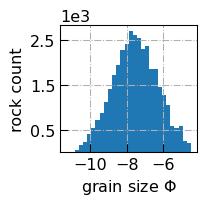

In [8]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 12})

size = (2.15, 2.15)
dpi = 96
fig = plt.figure(figsize = size, dpi=dpi)
plt.ylabel('rock count')
plt.xlabel('grain size $\Phi$')

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xticks(np.arange(-10, 1, 2.0))
plt.yticks(np.arange(500, 3000, 1000))
plt.hist(phi[phi<5], bins=30)
plt.tick_params(direction="in", length=6)
plt.grid(linestyle='-.')

set_size(fig, size, dpi=dpi)
#plt.savefig('paper_figures/f6_0.svg', format='svg')
plt.show()

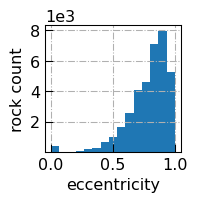

In [9]:
#ecc = c3_rock_shape.eccentrici.to_numpy()

areas = c3_rock_shape.area
ecc = c3_rock_shape.eccentrici[areas>0.000313].to_numpy()

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 12})

size = (2.05, 2.10)
dpi = 96
fig = plt.figure(figsize = size, dpi=dpi)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ylabel('rock count')
plt.xlabel('eccentricity')
plt.xticks(np.arange(0, 1.1, 0.5))
plt.yticks(np.arange(2000, 9000, 2000))
plt.tick_params(direction="in", length=6)
plt.hist(ecc, bins=15)
plt.grid(linestyle='-.')
set_size(fig, size, dpi=dpi)
plt.savefig('paper_figures/f6_1.svg', format='svg')
plt.show()

In [10]:
print(ecc[ecc>0.5].shape)
print(ecc[ecc<=0.5].shape)
(34039-2460)/34039.

(33833,)
(2300,)


0.9277299568142425

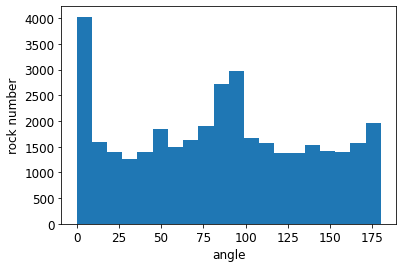

In [11]:
areas = c3_rock_shape.area
angle = c3_rock_shape.angle[areas>0.000313].to_numpy()
#angle = c3_rock_shape.angle[areas>0.5].to_numpy()
plt.ylabel('rock number')
plt.xlabel('angle')
plt.hist(angle, bins=20)
plt.show()

In [12]:
nm, ang = np.histogram(angle, bins=40)
print(nm)
print(ang)

[3014 1014  854  744  744  655  635  622  755  641 1082  755  710  786
  774  858  863 1038 1306 1417 1809 1171  864  802  807  759  706  680
  702  678  891  645  713  700  675  731  762  813  945 1013]
[  0.    4.5   9.   13.5  18.   22.5  27.   31.5  36.   40.5  45.   49.5
  54.   58.5  63.   67.5  72.   76.5  81.   85.5  90.   94.5  99.  103.5
 108.  112.5 117.  121.5 126.  130.5 135.  139.5 144.  148.5 153.  157.5
 162.  166.5 171.  175.5 180. ]


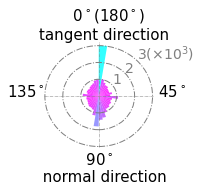

In [13]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 14})

size = (2.08,2.0)
dpi = 96

nm, ang = np.histogram(angle, bins=40)
fig, ax = plt.subplots(figsize=size)
lim = np.max(nm) + 20
plt.xlim(-lim-200,lim+200)
plt.ylim(-lim-200,lim+200)
patches = []
y0 = x0 = 0

#image = np.zeros((y0,y0,3), dtype='uint8')
#c = np.array([np.cos(np.deg2rad(x)) for x in range(0,95,10)])
#s = np.array([np.sin(np.deg2rad(x)) for x in range(0,95,10)])
colors = []

for i in range(nm.shape[0]):
    angle1 = ang[i+1]*2
    angle2 = ang[i]*2
    r = nm[i]
    y1 = r*np.cos(np.deg2rad(angle1))
    x1 = r*np.sin(np.deg2rad(angle1))
    y2 = r*np.cos(np.deg2rad(angle2))
    x2 = r*np.sin(np.deg2rad(angle2))
    pts = np.array(((x0,y0),(x1,y1),(x2,y2)))
    poly = plt.Polygon(pts, color='blue')
    patches.append(poly)
    colors.append(1 - r/lim)

p = PatchCollection(patches, cmap=matplotlib.cm.cool, alpha=0.8)
p.set_array(np.array(colors))
ax.add_collection(p)

circle1 = plt.Circle((0, 0), 1000, color='gray', fill=False, linestyle='-.')
circle2 = plt.Circle((0, 0), 2000, color='gray', fill=False, linestyle='-.')
circle3 = plt.Circle((0, 0), 3000, color='gray', fill=False, linestyle='-.')
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle3)
ax.text(740, 740, '1', fontsize=14, color='gray')
ax.text(1440, 1440, '2', fontsize=14, color='gray')
ax.text(2140, 2240, r'$3(\times 10^3)$', fontsize=14, color='gray')

ax.text(-3300, 3400, '       $0^\circ (180^\circ )$ \ntangent direction', fontsize=15)
ax.text(3300, 0, '$45^\circ$', fontsize=15)
ax.text(-3400, -5100, '          $90^\circ$ \n normal direction', fontsize=15)
ax.text(-5100, 0, '$135^\circ$', fontsize=15)

plt.plot((-lim, lim), (0,0), color='gray', linestyle='-.', linewidth=0.5)
plt.plot((-0, 0), (-lim,lim+1000), color='gray', linestyle='-.', linewidth=0.5)

plt.axis('OFF')

#set_size(fig, size, dpi=dpi)
#plt.savefig('paper_figures/f6_2.png', format='png')
plt.show()

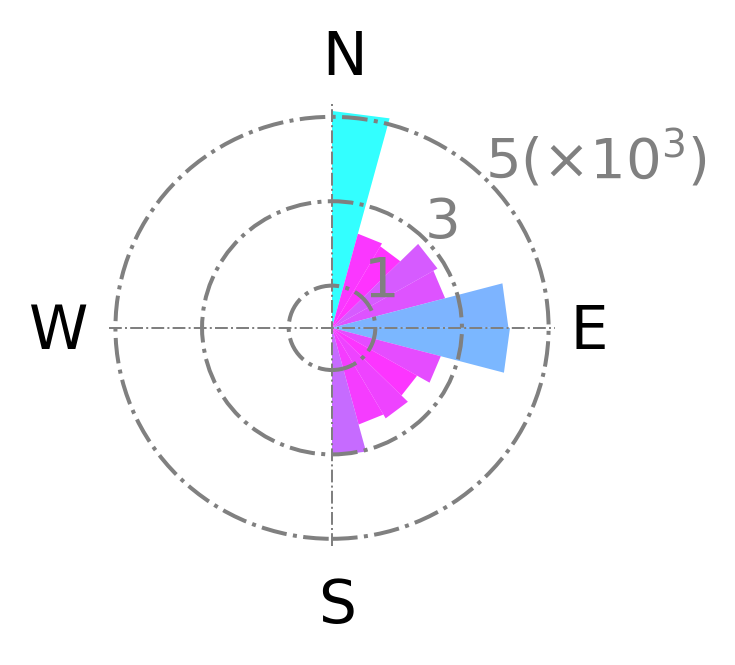

In [14]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 14})

size = (2.08,2.08)
dpi = 96

nm, ang = np.histogram(angle, bins=12)
fig, ax = plt.subplots(figsize=size, dpi=96*3)
lim = np.max(nm) + 20
plt.xlim(-lim-200,lim+200)
plt.ylim(-lim-200,lim+200)
patches = []
y0 = x0 = 0

#image = np.zeros((y0,y0,3), dtype='uint8')
#c = np.array([np.cos(np.deg2rad(x)) for x in range(0,95,10)])
#s = np.array([np.sin(np.deg2rad(x)) for x in range(0,95,10)])
colors = []

for i in range(nm.shape[0]):
    angle1 = ang[i+1]
    angle2 = ang[i]
    r = nm[i]
    y1 = r*np.cos(np.deg2rad(angle1))
    x1 = r*np.sin(np.deg2rad(angle1))
    y2 = r*np.cos(np.deg2rad(angle2))
    x2 = r*np.sin(np.deg2rad(angle2))
    pts = np.array(((x0,y0),(x1,y1),(x2,y2)))
    poly = plt.Polygon(pts, color='blue')
    patches.append(poly)
    colors.append(1 - r/lim)

p = PatchCollection(patches, cmap=matplotlib.cm.cool, alpha=0.8)
p.set_array(np.array(colors))
ax.add_collection(p)

circle1 = plt.Circle((0, 0), 1000, color='gray', fill=False, linestyle='-.')
circle2 = plt.Circle((0, 0), 3000, color='gray', fill=False, linestyle='-.')
circle3 = plt.Circle((0, 0), 5000, color='gray', fill=False, linestyle='-.')
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle3)
ax.text(740, 740, '1', fontsize=14, color='gray')
ax.text(2140, 2140, '3', fontsize=14, color='gray')
ax.text(3540, 3540, r'$5(\times 10^3)$', fontsize=14, color='gray')

ax.text(-3300, 6000, '       N', fontsize=15)
ax.text(3300, -500, '     E', fontsize=15)
ax.text(-3400, -7000, '       S', fontsize=15)
ax.text(-7000, -500, 'W', fontsize=15)

plt.plot((-lim, lim), (0,0), color='gray', linestyle='-.', linewidth=0.5)
plt.plot((-0, 0), (-lim,lim+1000), color='gray', linestyle='-.', linewidth=0.5)

plt.axis('OFF')

#set_size(fig, size, dpi=dpi)
#plt.savefig('paper_figures/f6_2.png', format='png')
plt.show()

# slice shapefile with horizonal lines

Coorelation between rock size and scarp height

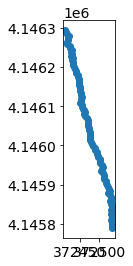

In [15]:
# read height shape file
height_shape = gpd.read_file("Bishop_scarp_height/c3_scarp_height_filtered.shp")
height_shape.plot()

In [16]:
heights = height_shape['Height']

z = heights.to_numpy().reshape(-1, 1)
x = height_shape['geometry'].x.to_numpy().reshape(-1, 1)
y = height_shape['geometry'].y.to_numpy().reshape(-1, 1)

height_pts = np.concatenate((x, y, z), axis = 1)
#print(height_pts)

In [17]:
# slice rocks with horizonal lines
# if you change step size here, then run the closely following cells
longitude0, latitude0, longitude1, latitude1 = c3.rio.bounds()
step = 30  # step size of the mesh grids (meters)
nm_lat = int((latitude1 - latitude0)/step)  # cell numbers along altitude
print("cell numbers on latitude: ", nm_lat)


cell numbers on latitude:  16


In [ ]:
# only run this at first time
!rm c3_rocks/filtered_v1/sliced_shapefile/*

size = 0
for idx_y in range(nm_lat):
  y0 = latitude0 + step*idx_y
  y1 = latitude0 + step*idx_y + step
  box_shape = c3_rock_shape.cx[:, y0:y1]
  file_name = 'c3_rocks/filtered_v1/sliced_shapefile/' + str(idx_y) + ".shp"
  if box_shape.shape[0] > 50:
    box_shape.to_file(file_name)
    size = size + box_shape.shape[0]
    print(idx_y, box_shape.shape[0])

0 626
1 1239
2 1246
3 1593
4 1976
5 1901
6 2475
7 2456
8 2437
9 2873
10 2696
11 2295
12 2221
13 2701
14 2848
15 2870


In [ ]:
# only run this cell at first time
shapefiles = [f for f in os.listdir('c3_rocks/filtered_v1/sliced_shapefile/') if f.endswith('.shp')]

shape_dict = {}

for shapefile in shapefiles:
  f = os.path.join('c3_rocks/filtered_v1/sliced_shapefile/', shapefile)
  rock_shp = gpd.read_file(f)
  #coords = tuple([int(i) for i in shapefile.split('.')[0].split('_')])
  coords = int(shapefile.split('.')[0])
  shape_dict[coords] = rock_shp

with open('c3_rocks/filtered_v1/sliced_shapefile_dict.pickle', 'wb') as handle:
    pickle.dump(shape_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
with open('c3_rocks/filtered_v1/sliced_shapefile_dict.pickle', 'rb') as handle:
    shape_dict = pickle.load(handle)

# Coorelation between rock size and scarp height

In [20]:
# get (latitude, height, phi_50, variance) along fault scarp

lats = height_pts[:, 1]
lats[np.isnan(lats)] = 1e10


def area2phi(area):
  D_mm = np.sqrt(area * 10**6/pi)*2
  phi = -np.log2(D_mm)
  return phi


lat_height_size_var = []

for i in range(nm_lat):
  if i not in shape_dict.keys():
    continue
  shp = shape_dict[i]
  y = latitude0 + step*i + step/2.
  idx = np.argmin(np.abs(lats - y))
  #print(np.abs(lats - y))
  #print(np.abs(lats - y)[idx])
  #print(idx)
  height = height_pts[idx, 2]
  area = shp.area
  area = area[area!=0]
  area = area[area>0.000314]
  mean = area.mean()
  phi = area2phi(area)
  phi_50 = phi.median()
  var = phi[phi!=inf].var()
  lat_height_size_var.append((y, height, phi_50, var))

lat_height_size_var = np.asarray(lat_height_size_var)

In [21]:
 # sorting = (ϕ84 – ϕ16 /4) + (ϕ95 – ϕ5 / 6.6)

def get_sorting(phi):
  p = np.copy(phi)
  n = p.shape[0]
  p_16 = p[int(0.16*n)]
  p_84 = p[int(0.84*n)]
  p_95 = p[int(0.95*n)]
  p_5 = p[int(0.5*n)]
  return (p_84 - p_16/4) + (p_95 - p_5/6.6)

lat_height_size_sorting = []

for i in range(nm_lat):
  if i not in shape_dict.keys():
    continue
  shp = shape_dict[i]
  y = latitude0 + step*i + step/2.
  idx = np.argmin(np.abs(lats - y))
  #print(np.abs(lats - y))
  #print(np.abs(lats - y)[idx])
  #print(idx)
  height = height_pts[idx, 2]
  area = shp.area
  area = area[area!=0]
  area = area[area>0.000314]
  phi = area2phi(area)
  phi_50 = phi.median()
  #var = phi[phi!=inf].var()
  sorting = get_sorting(phi)
  lat_height_size_sorting.append((y, height, phi_50, var))

lat_height_size_sorting = np.asarray(lat_height_size_var)

In [ ]:
lat_height_size_var[:, 2]

array([-7.82634495, -7.69553116, -7.69130037, -7.66096897, -7.58151718,
       -7.67845704, -7.5715674 , -7.5715674 , -7.67412461, -7.53824403,
       -7.38381283, -7.54607543, -7.44603652, -7.47524486, -7.46660005,
       -7.46370305])

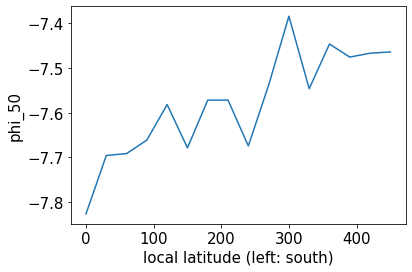

In [ ]:
# skip running this one
plt.plot(lat_height_size_var[:,0]-lat_height_size_var[:,0][0], lat_height_size_var[:,2])
plt.xlabel('local latitude (left: south)')
plt.ylabel('phi_50')
plt.show()

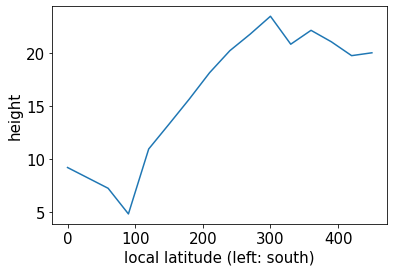

In [ ]:
# skip running this one
plt.plot(lat_height_size_var[:,0]-lat_height_size_var[:,0][0], lat_height_size_var[:,1])
plt.xlabel('local latitude (left: south)')
plt.ylabel('height')
plt.show()
np.save('profile_data/lat_height_size_var.npy', lat_height_size_var)

In [ ]:
# skip running this one
# get (latitude, height, phi_50, variance) along fault scarp

lats = height_pts[:, 1]
lats[np.isnan(lats)] = 1e10

height_idx = []

for i in range(nm_lat):
  if i not in shape_dict.keys():
    continue
  shp = shape_dict[i]
  y = latitude0 + step*i + step/2.
  idx = np.argmin(np.abs(lats - y))
  #print(np.abs(lats - y))
  #print(np.abs(lats - y)[idx])
  #print(idx)
  height_idx.append(idx)

new_height_pts = height_pts[height_idx,:]

In [ ]:
# skip running this one
# 1. define schema
# ref: https://hatarilabs.com/ih-en/how-to-create-a-pointlinepolygon-shapefile-with-python-and-fiona-tutorial
schema = {
    'geometry':'Point',
    'properties':[('Height','float')]
}

# 2. open a write file
polyShp = fiona.open('Bishop_scarp_height/middle_height_pts.shp', mode='w', driver='ESRI Shapefile', schema = schema, crs = c3.rio.crs)

# 3. add polygons to file
for d in new_height_pts:
  rowDict = {'geometry' : {'type':'Point', 'coordinates': [d[0], d[1]]}, 'properties': {'Height': d[2]}}
  polyShp.write(rowDict)

# 4. write file
polyShp.close()

In [22]:
phi = area2phi(area)
phi_50 = phi.median()
print(phi_50)  # median of phi
print(area2phi(area.median()))  # phi of median

-7.463703052717229
-7.463703052717229


In [23]:
l = lat_height_size_var[:, 0] - lat_height_size_var[:, 0][0]

s = lat_height_size_var[:, 2]
s_M = -7.35
s_N = -7.85

h = lat_height_size_var[:, 1]
h_M = 26
h_N = 3

h_in_s = (h - h_N) / (h_M - h_N) * (s_M - s_N) + s_N

y = np.concatenate((s, h_in_s))
x = np.concatenate((l, l))

m, b = np.polyfit(x, y, 1)

In [24]:
a, d = np.polyfit(h, s, 1)
cor, p = pearsonr(lat_height_size_var[:, 2], lat_height_size_var[:, 1])
print("The correlation between height and phi_50 is ", cor)
print("{:.3e}".format(p))
print(r2_score(s, a*h + d))
print(cor**2)

The correlation between height and phi_50 is  0.7766042720155824
4.028e-04
0.6031141953128523
0.6031141953128526


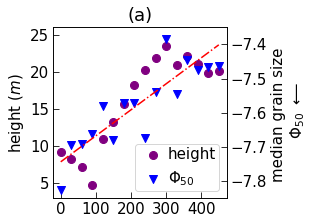

In [ ]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 15})

fig, ax1 = plt.subplots()
plt.title('(a)')
ax2 = ax1.twinx()

ax2.plot(l, m*l + b, color='red', linestyle='-.')

#ax1.set_xlabel('latitude ($m$)')
ax1.set_ylabel('height ($m$)')
s1 = ax1.scatter(l, h, color='purple', label='height', s=2**6)
ax1.tick_params(axis='y')
ax1.tick_params(direction="in", length=6)
ax1.set_ylim(h_N,h_M)
ax1.set_yticks(range(5,26,5))
ax1.set_xticks(range(0,401,100))

ax2.set_ylabel('median grain size \n $\Phi_{50}$ $\longleftarrow$')  # we already handled the x-label with ax1
s2 = ax2.scatter(l, s, color='blue', label="$\Phi_{50}$", s=2**6, marker="v")
ax2.tick_params(axis='y')
ax2.tick_params(direction="in", length=6)
ax2.set_ylim(s_N, s_M)
ax2.set_yticks(np.arange(-7.8,-7.30, 0.1))

ax1.legend([s1, s2], [s1.get_label(), s2.get_label()], loc='lower right', handletextpad=0, borderpad=0.2)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

set_size(fig, (4.25, 3.1), dpi=96*3)


plt.show()



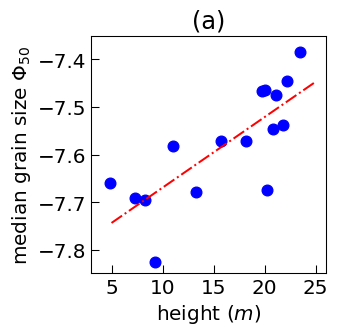

In [25]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(figsize=(3.75, 3.75), dpi=96)
plt.title('(a)')

plt.ylim(s_N,s_M)
plt.xlim(3, 26)
plt.scatter(h, s, color='blue', label='height', s=2**6)

m, b = np.polyfit(h, s, 1)
x = np.array((5, 25))
plt.plot(x, m*x + b, color='red', linestyle='-.')

plt.tick_params(axis='y')
plt.tick_params(direction="in", length=6)

plt.xticks(range(5,26,5))

plt.xlabel('height ($m$)')
plt.ylabel('median grain size $\Phi_{50}$')

fig.tight_layout()  # otherwise the right y-label is slightly clipped


plt.show()


In [26]:
l = lat_height_size_var[:, 0] - lat_height_size_var[:, 0][0]

v = lat_height_size_var[:, 3]
v_M = 1.9
v_N = 1.1

h = lat_height_size_var[:, 1]
h_M = 26
h_N = 3

h_in_v = (h - h_N) / (h_M - h_N) * (v_M - v_N) + v_N

y = np.concatenate((v, h_in_v))
x = np.concatenate((l, l))

m, b = np.polyfit(x, y, 1)
print(r2_score(m*x + b, y))

0.373301329238211


In [27]:
a, d = np.polyfit(h, v, 1)
cor, p = pearsonr(lat_height_size_var[:, 1], lat_height_size_var[:, 3])
print("The correlation between height and variance is ", cor)
print("The p-value is ", "{:.3e}".format(p))
print(r2_score(v, a*h + d))

The correlation between height and variance is  0.89826478547142
The p-value is  2.303e-06
0.8068796248180162


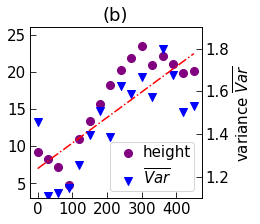

In [28]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 15})

fig, ax1 = plt.subplots()
plt.title('(b)')
ax2 = ax1.twinx()

ax2.plot(l, m*l + b, color='red', linestyle='-.')

#ax1.set_xlabel('latitude ($m$)')
#ax1.set_ylabel('height ($m$)')
s1 = ax1.scatter(l, h, color='purple', label='height', s=2**6)
ax1.tick_params(axis='y')
ax1.tick_params(direction="in", length=6)
ax1.set_ylim(h_N,h_M)
ax1.set_yticks(range(5,26,5))
ax1.set_xticks(range(0,401,100))

ax2.set_ylabel('variance $\overline{Var}$')  # we already handled the x-label with ax1
s2 = ax2.scatter(l, v, color='blue', label="$\overline{Var}$", s=2**6, marker="v")
ax2.tick_params(axis='y')
ax2.tick_params(direction="in", length=6)
ax2.set_ylim(v_N,v_M)
ax2.set_yticks(np.arange(1.2,1.9, 0.2))

ax1.legend([s1, s2], [s1.get_label(), s2.get_label()], loc='lower right', handletextpad=0, borderpad=0.2)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

set_size(fig, (3.55, 3.1), dpi=96*3)


plt.show()

In [29]:
v = lat_height_size_var[:, 3] 

h = lat_height_size_var[:, 1]

a, d = np.polyfit(h, v, 1)
cor, p = pearsonr(lat_height_size_var[:, 1], lat_height_size_var[:, 3])
print("The correlation between height and variance is ", cor)
print("The p-value is ", "{:.3e}".format(p))
print(r2_score(s, a*h + d))
print(cor**2)


The correlation between height and variance is  0.89826478547142
The p-value is  2.303e-06
-6274.01955667355
0.8068796248180161


In [30]:
s = lat_height_size_sorting[:, 3] 

h = lat_height_size_var[:, 1]


In [31]:
a, d = np.polyfit(h, s, 1)
cor, p = pearsonr(lat_height_size_sorting[:, 1], lat_height_size_sorting[:, 3])
print("The correlation between height and sorting is ", cor)
print("The p-value is ", "{:.3e}".format(p))
print(r2_score(s, a*h + d))
print(cor**2)

The correlation between height and sorting is  0.89826478547142
The p-value is  2.303e-06
0.8068796248180162
0.8068796248180161


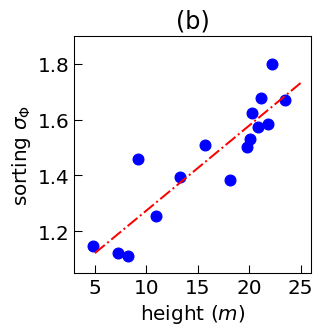

In [34]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(figsize=(3.6,3.75), dpi=96)
plt.title('(b)')

plt.ylim(1.05, 1.9)
plt.xlim(3, 26)
plt.scatter(h, s, color='blue', label='height', s=2**6)
plt.yticks(np.arange(1.2, 1.8, 0.2))

m, b = np.polyfit(h, s, 1)
x = np.array((5, 25))
plt.plot(x, m*x + b, color='red', linestyle='-.')

plt.tick_params(axis='y')
plt.tick_params(direction="in", length=6)

plt.xticks(range(5,26,5))

plt.xlabel('height ($m$)')
plt.ylabel('sorting $\sigma_{\Phi}$')

fig.tight_layout()  # otherwise the right y-label is slightly clipped


plt.show()


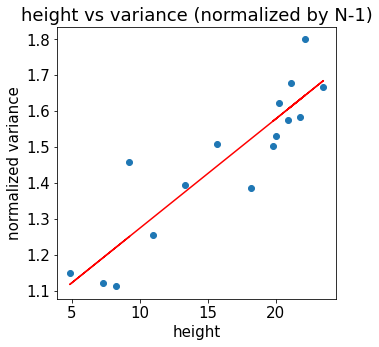

<Figure size 1800x1200 with 0 Axes>

The correlation between height and variance is  0.89826478547142
The p-value is  2.302620519906603e-06
0.8068796248180162


In [35]:
plt.figure(figsize = (5, 5))
plt.scatter(lat_height_size_var[:, 1], lat_height_size_var[:, 3])
m, b = np.polyfit(lat_height_size_var[:, 1], lat_height_size_var[:, 3], 1)
plt.plot(lat_height_size_var[:, 1], m*lat_height_size_var[:, 1] + b, color='r')
plt.title('height vs variance (normalized by N-1)')
plt.xlabel('height')
plt.ylabel('normalized variance')
plt.figure(dpi=300)
plt.show()

cor, p = pearsonr(lat_height_size_var[:, 1], lat_height_size_var[:, 3])
print("The correlation between height and variance is ", cor)
print("The p-value is ", p)
print(r2_score(lat_height_size_var[:, 3], lat_height_size_var[:, 1]*m + b))

In [36]:
# the number of small rocks indicates geomorphic fracturing 
# how about large rocks that indicate tectonic faulting ?

# get (latitude, height, mean of the largest rocks) along fault scarp

lats = height_pts[:, 1]
lats[np.isnan(lats)] = 1e10


def area2phi(area):
  D_mm = np.sqrt(area * 10**6/pi)*2
  phi = -np.log2(D_mm)
  return phi


lat_height_largesize = []

for i in range(nm_lat):
  if i not in shape_dict.keys():
    continue
  shp = shape_dict[i]
  y = latitude0 + step*i + step/2.
  idx = np.argmin(np.abs(lats - y))
  #print(np.abs(lats - y))
  #print(np.abs(lats - y)[idx])
  #print(idx)
  height = height_pts[idx, 2]
  area = shp.area
  area = area[area>0.000314]
  area_nd = area.to_numpy()
  indices = (-area_nd).argsort()[:10]  # largest 10 rocks
  large_mean = area_nd[indices].mean()
  lat_height_largesize.append((y, height, area2phi(large_mean)))

lat_height_largesize = np.asarray(lat_height_largesize)

In [ ]:
# skip running this one
np.save('profile_data/lat_height_largesize.npy', lat_height_largesize)

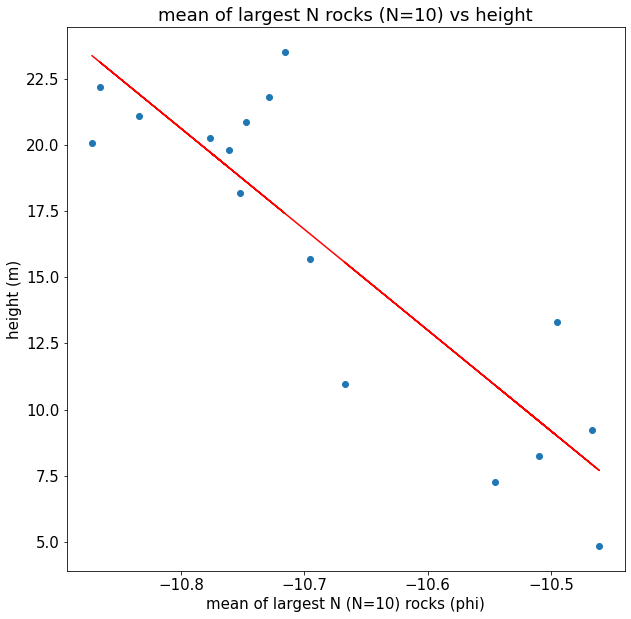

<Figure size 1800x1200 with 0 Axes>

The correlation between large rock phi and largest_rock_size is  -0.8724032498660672
The p-value is  1.0468869865369604e-05
0.7610874303768761
0.7610874303768757


In [37]:
# plot size vs height

plt.figure(figsize = (10, 10))
plt.scatter(lat_height_largesize[:, 2], lat_height_largesize[:, 1])

m, b = np.polyfit(lat_height_largesize[:, 2], lat_height_largesize[:, 1], 1)
plt.plot(lat_height_largesize[:, 2], m*lat_height_largesize[:, 2] + b, color='r')

plt.title('mean of largest N rocks (N=10) vs height')
plt.xlabel('mean of largest N (N=10) rocks (phi)')
plt.ylabel('height (m)')
plt.figure(dpi=300)
plt.show()

cor, p = pearsonr(lat_height_largesize[:, 2], lat_height_largesize[:, 1])
print("The correlation between large rock phi and largest_rock_size is ", cor)
print("The p-value is ", p)
print(r2_score(lat_height_largesize[:, 1], lat_height_largesize[:, 2]*m + b))
print(cor**2)

In [38]:
l = lat_height_largesize[:, 0] - lat_height_largesize[:, 0][0]

s = lat_height_largesize[:, 2]
s_M = -10.45
s_N = -10.92

h = lat_height_largesize[:, 1]
h_M = 26  # neg h
h_N = 3  # neg h

h_in_s = (h - h_N) / (h_M - h_N) * (s_N - s_M) + s_M

y = np.concatenate((s, h_in_s))
x = np.concatenate((l, l))

m, b = np.polyfit(x, y, 1)

In [39]:
a, d = np.polyfit(h, -s, 1)
cor, p = pearsonr(lat_height_largesize[:, 2], lat_height_largesize[:, 1])
print("The correlation between large rock phi and largest_rock_size is ", cor)
print("The p-value is ", p)
print(r2_score(-s, a*h + d))

The correlation between large rock phi and largest_rock_size is  -0.8724032498660672
The p-value is  1.0468869865369604e-05
0.761087430376876


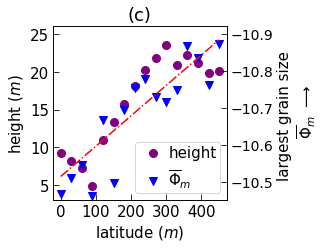

In [40]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 15})

fig, ax1 = plt.subplots()
plt.title('(c)')
ax2 = ax1.twinx()
ax2.invert_yaxis()

ax2.plot(l, m*l + b, color='red', linestyle='-.')

ax1.set_xlabel('latitude ($m$)')
ax1.set_ylabel('height ($m$)')
s1 = ax1.scatter(l, h, color='purple', label='height', s=2**6)
ax1.tick_params(axis='y')
ax1.tick_params(direction="in", length=6)
ax1.set_ylim(h_N,h_M)
ax1.set_yticks(range(5,26,5))
ax1.set_xticks(range(0,401,100))

ax2.set_ylabel('largest grain size \n $\overline{\Phi}_m$ $\longrightarrow$')  # we already handled the x-label with ax1
s2 = ax2.scatter(l, s, color='blue', label="$\overline{\Phi}_m$", s=2**6, marker="v")
ax2.tick_params(axis='y')
ax2.tick_params(direction="in", length=6)
ax2.tick_params(axis='y', which='major', labelsize=14)
ax2.set_ylim(s_M,s_N)
ax2.set_yticks(np.arange(-10.5,-10.9, -0.1))

ax1.legend([s1, s2], [s1.get_label(), s2.get_label()], loc='lower right', handletextpad=0, borderpad=0.2)
fig.tight_layout()  # otherwise the right y-label is slightly clipped


set_size(fig, (4.4, 3.4), dpi=96*3)


plt.show()

In [41]:
a, d = np.polyfit(h, -s, 1)
cor, p = pearsonr(lat_height_largesize[:, 2], lat_height_largesize[:, 1])
print("The correlation between large rock phi and largest_rock_size is ", cor)
print("The p-value is ", p)
print(r2_score(-s, a*h + d))

The correlation between large rock phi and largest_rock_size is  -0.8724032498660672
The p-value is  1.0468869865369604e-05
0.761087430376876


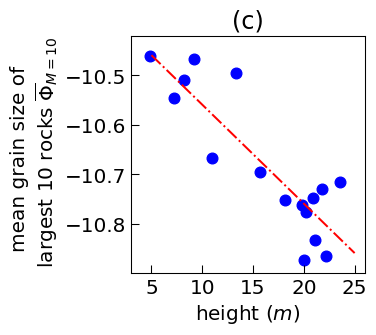

In [55]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(figsize=(4.15, 3.75), dpi=96)
plt.title('(c)')

plt.ylim(-10.9, -10.42)
plt.xlim(3, 26)
plt.scatter(h, s, color='blue', label='height', s=2**6)
plt.yticks(np.arange(-10.8, -10.5, 0.1))

m, b = np.polyfit(h, s, 1)
x = np.array((5, 25))
plt.plot(x, m*x + b, color='red', linestyle='-.')

plt.tick_params(axis='y')
plt.tick_params(direction="in", length=6)

plt.xticks(range(5,26,5))

plt.xlabel('height ($m$)')
plt.ylabel('mean grain size of \n largest 10 rocks $\overline{\Phi}_{M=10}$')

fig.tight_layout()  # otherwise the right y-label is slightly clipped


plt.show()

In [ ]:
# ratios of small rock count : large rock count


lats = height_pts[:, 1]
lats[np.isnan(lats)] = 1e10


def area2phi(area):
  D_mm = np.sqrt(area * 10**6/pi)*2
  phi = -np.log2(D_mm)
  return phi


lat_height_ratio = []

for i in range(nm_lat):
  if i not in shape_dict.keys():
    continue
  shp = shape_dict[i]
  y = latitude0 + step*i + step/2.
  idx = np.argmin(np.abs(lats - y))
  #print(np.abs(lats - y))
  #print(np.abs(lats - y)[idx])
  #print(idx)
  height = height_pts[idx, 2]
  area = shp.area
  area = area[area!=0]
  area = area[area>0.000314]
  phi = area2phi(area)
  phi_small = phi[phi>-8]
  phi_large = phi[phi<=-8]
  lat_height_ratio.append((y, height, phi_small.count()/phi_large.count()))

lat_height_ratio = np.asarray(lat_height_ratio)

In [ ]:
l = lat_height_ratio[:, 0] - lat_height_ratio[:, 0][0]

r = lat_height_ratio[:, 2]
r_M = 2.15
r_N = 1.25

h = lat_height_ratio[:, 1]
h_M = 26
h_N = 3

h_in_r = (h - h_N) / (h_M - h_N) * (r_M - r_N) + r_N

y = np.concatenate((r, h_in_r))
x = np.concatenate((l, l))

m, b = np.polyfit(x, y, 1)

In [ ]:
a, d = np.polyfit(h, r, 1)
cor, p = pearsonr(lat_height_ratio[:, 2], lat_height_ratio[:, 1])
print("The correlation between large rock phi and largest_rock_size is ", cor)
print("The p-value is ", "{:.3e}".format(p))
print(r2_score(r, a*h + d))
print(cor**2)

The correlation between large rock phi and largest_rock_size is  0.6430398727723525
The p-value is  7.209e-03
0.41350027797508326
0.4135002779750833


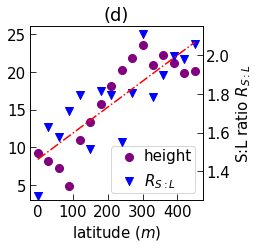

In [ ]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 15})

fig, ax1 = plt.subplots()
plt.title('(d)')
ax2 = ax1.twinx()

ax2.plot(l, m*l + b, color='red', linestyle='-.')

ax1.set_xlabel('latitude ($m$)')
#ax1.set_ylabel('height ($m$)')
s1 = ax1.scatter(l, h, color='purple', label='height', s=2**6)
ax1.tick_params(axis='y')
ax1.tick_params(direction="in", length=6)
ax1.set_ylim(h_N,h_M)
ax1.set_yticks(range(5,26,5))
ax1.set_xticks(range(0,401,100))

ax2.set_ylabel('S:L ratio $R_{S:L}$')  # we already handled the x-label with ax1
s2 = ax2.scatter(l, r, color='blue', label="$R_{S:L}$", s=2**6, marker="v")
ax2.tick_params(axis='y')
ax2.tick_params(direction="in", length=6)
ax2.set_ylim(r_N,r_M)
ax2.set_yticks(np.arange(1.4,2.0, 0.2))

ax1.legend([s1, s2], [s1.get_label(), s2.get_label()], loc='lower right', handletextpad=0, borderpad=0.2)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

set_size(fig, (3.55, 3.4), dpi=96*3)


plt.show()

In [ ]:
a, d = np.polyfit(h, r, 1)
cor, p = pearsonr(lat_height_ratio[:, 2], lat_height_ratio[:, 1])
print("The correlation between large rock phi and largest_rock_size is ", cor)
print("The p-value is ", "{:.3e}".format(p))
print(r2_score(r, a*h + d))
print(cor**2)

The correlation between large rock phi and largest_rock_size is  0.632697304800621
The p-value is  8.531e-03
0.40030587950196994
0.40030587950196994


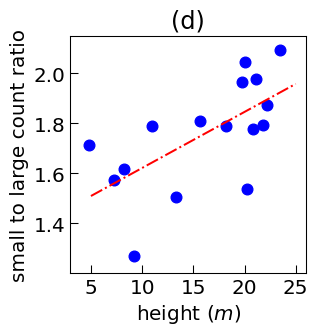

In [ ]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(figsize=(3.55, 3.75), dpi=96)
plt.title('(d)')

plt.ylim(1.2, 2.15)
plt.xlim(3, 26)
plt.scatter(h, r, color='blue', label='height', s=2**6)
plt.yticks(np.arange(1.4, 2, 0.2))

m, b = np.polyfit(h, r, 1)
x = np.array((5, 25))
plt.plot(x, m*x + b, color='red', linestyle='-.')

plt.tick_params(axis='y')
plt.tick_params(direction="in", length=6)

plt.xticks(range(5,26,5))

plt.xlabel('height ($m$)')
plt.ylabel('small to large count ratio')

fig.tight_layout()  # otherwise the right y-label is slightly clipped


plt.show()

# orientation analysis

1. slice fault scarp with horizontal lines
2. adjust angle baseline for each segments
3. analyze orientation stats

We shouldn't use absolute angles because orientation change should be consistent on either clockwise or counter-clockwise rotations. Instead, I use the deviation of the scarp's normal direction to represent rock orientation.

For example, sin or cos can be used as deviation functions. 

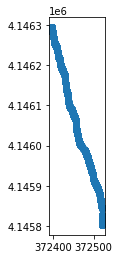

In [ ]:
# read fault scarp middle line
sk_shape = gpd.read_file("skeleton/skeleton_Point.shp")
sk_shape.plot()

In [ ]:
# segment middle line with the mesh grid
_, _, baseline, _ = c3.rio.bounds()


tan_vectors = []  # tangent vectors of the scarp outline from bottom to top

for idx_y in range(nm_lat):
  # get points in each mesh grid
  y0 = latitude0 + step*idx_y
  y1 = latitude0 + step*idx_y + step
  box_sk_shape = sk_shape.cx[:, y0:y1]
  pts_x = box_sk_shape['geometry'].x.to_numpy().reshape(-1, 1)
  pts_y = box_sk_shape['geometry'].y.to_numpy().reshape(-1, 1)
  pts = np.concatenate((pts_x, pts_y), axis=1)
  # linear regression: approximate a line to get normal or tangent vector
  a, b = np.polyfit(pts[:, 0], pts[:, 1], 1)
  tan_v = np.array((1/a, 1.0))
  tan_v = tan_v / np.linalg.norm(tan_v)  # (y, x)
  tan_vectors.append(tan_v)



In [ ]:
# convert tangent vectors to shifted angle in degree
tan_angles = [90-np.arctan(v[1]/v[0])*180/pi for v in tan_vectors] # also the angles should be consistent with rock orientation coordinates: Up-Clockwise
tan_angles

[173.46097749242168,
 177.5434050022297,
 170.87346172157584,
 158.8060010666527,
 166.2402783177825,
 163.24873257530948,
 158.59335955174993,
 159.67335371066144,
 170.97676965537795,
 160.88243599606307,
 159.49532449076315,
 168.4460440611395,
 174.08960116490277,
 157.54220489366116,
 166.11660866147224,
 160.20235969807754]

In [ ]:
c3_rock_shape = gpd.read_file("c3_rocks/filtered_v1/rockPoly_filtered_v1.shp")
print(c3_rock_shape.shape)
areas = c3_rock_shape.area
c3_rock_shape = c3_rock_shape[areas>0.000314]

(36499, 7)


In [ ]:
# remove rocks with small eccentricity
# cirle eccentricity: 0

threshold = 0.00
idx = c3_rock_shape[c3_rock_shape['eccentrici'] < threshold].index
c3_rock_shape.drop(idx , inplace=True)
c3_rock_shape.shape

(36133, 7)

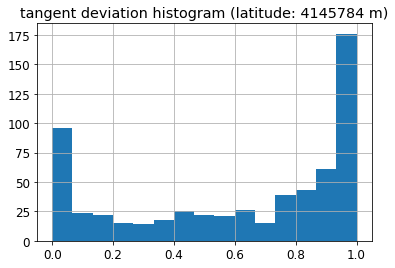

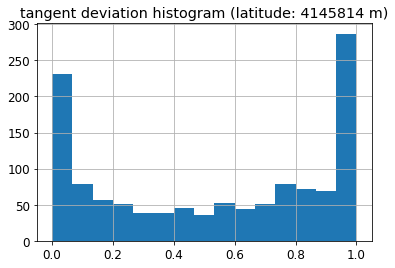

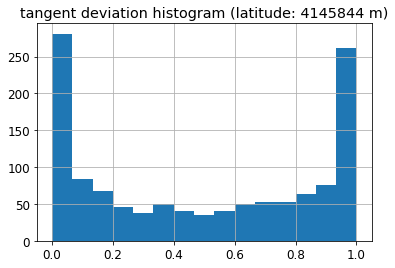

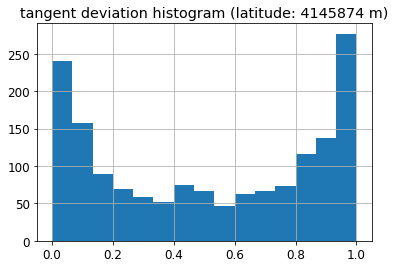

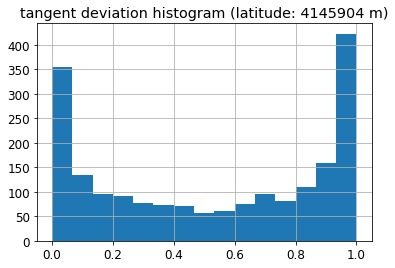

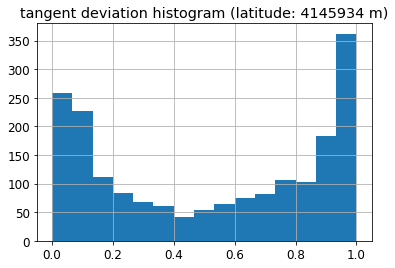

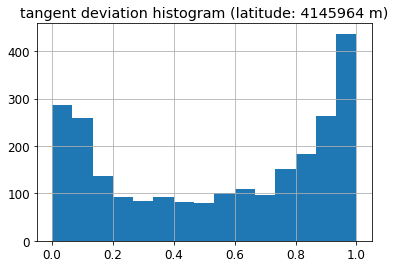

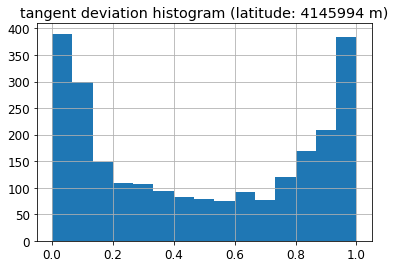

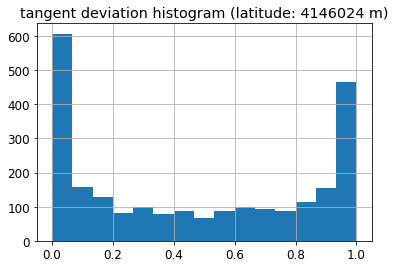

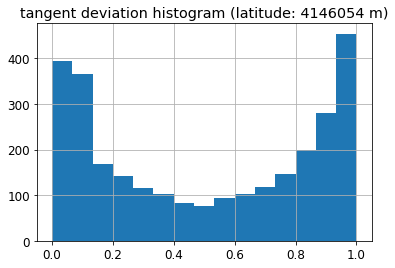

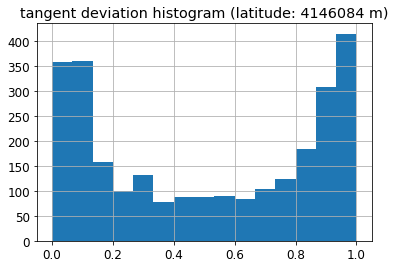

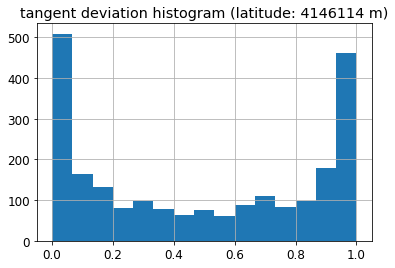

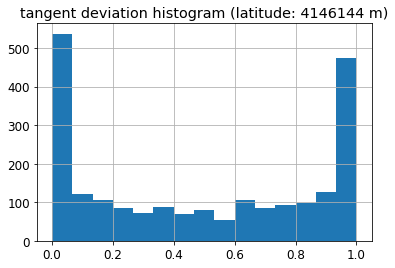

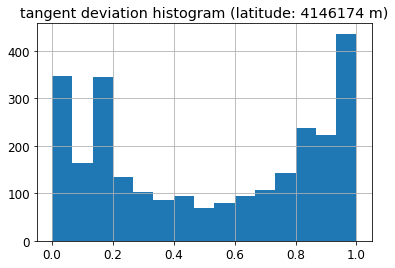

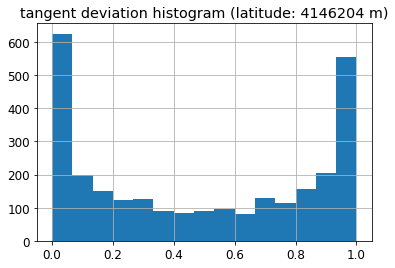

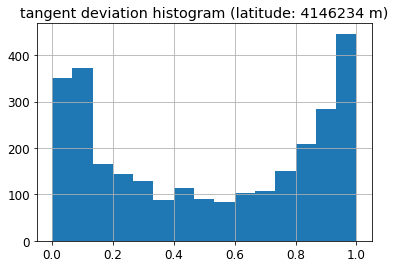

In [ ]:
# define a deviation function
def dev(angle, tan_angle):
  # y = [-cos(2*(x-tan_angle)) + 1] * 0.5
  # 0: close to tangent vector
  # 1: close to normal vector or perpendicular to tangent vector
  y = 0.5*(- np.cos(2*np.deg2rad(angle-tan_angle)) + 1)
  return y

deviations = []

for i in range(nm_lat):
  if i not in shape_dict.keys():
    continue
  tan_angle = tan_angles[i]
  y0 = latitude0 + step*i
  y1 = latitude0 + step*i + step
  box_rock_shape = c3_rock_shape.cx[:, y0:y1]
  angles = box_rock_shape['angle']
  devs = dev(angles, tan_angle)
  deviations.append(devs)
  devs.hist(bins=15)
  plt.title("tangent deviation histogram (latitude: {lat} m)".format(lat = int(y0)))
  plt.show()

### tangent deviation histogram for all rocks on the entire area

In [ ]:
# overall orientation

dev_all = []
for deviation in deviations:
  dev_nd = deviation.to_numpy().tolist()
  dev_all = dev_all + dev_nd

dev_all = np.asarray(dev_all)

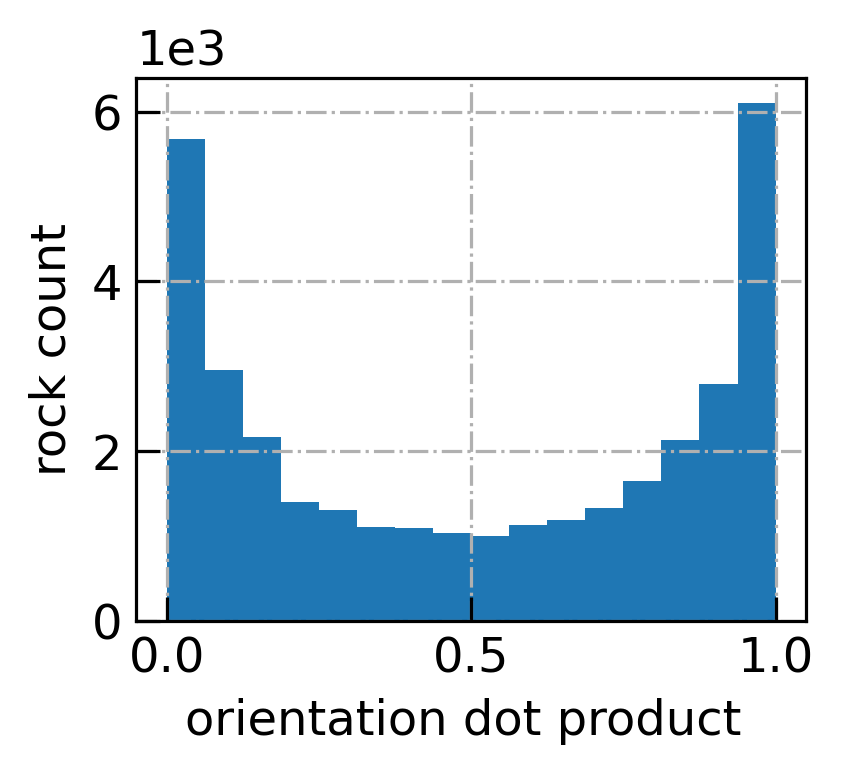

In [ ]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 12})

size = (3., 2.5)
dpi=96*3
plt.figure(figsize = size, dpi=dpi)
plt.hist(dev_all, bins = 16) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.grid(linestyle='-.')
plt.tick_params(direction="in", length=6)
#plt.title("tangent deviation histogram (entire fault scarp)") 
plt.xlabel("orientation dot product ")
plt.ylabel("rock count")
plt.show()

In [ ]:
# tangent:normal ratio vs height for all rocks on the entire area

# define a deviation function
def dev(angle, tan_angle):
  # y = [-cos(2*(x-tan_angle)) + 1] * 0.5
  # 0: close to tangent vector
  # 1: close to normal vector or perpendicular to tangent vector
  y = 0.5*(- np.cos(2*np.deg2rad(angle-tan_angle)) + 1)
  return y

lat_height_t2n = []

for i in range(nm_lat):
  if i not in shape_dict.keys():
    continue

  y = latitude0 + step*i + step/2.
  idx = np.argmin(np.abs(lats - y))
  #print(np.abs(lats - y))
  #print(np.abs(lats - y)[idx])
  #print(idx)
  height = height_pts[idx, 2]

  tan_angle = tan_angles[i]
  y0 = latitude0 + step*i
  y1 = latitude0 + step*i + step
  
  box_sk_shape = sk_shape.cx[:, y0:y1]
  mean_x = box_sk_shape['geometry'].x.mean()
  
  #box_rock_shape = c3_rock_shape.cx[:mean_x, y0:y1]  # rocks below the middle line
  box_rock_shape = c3_rock_shape.cx[:, y0:y1]  # all rocks on the entire area

  angles = box_rock_shape['angle']
  devs = dev(angles, tan_angle)
  
  
  tangent_nm = devs[devs < 0.5].index.shape[0]
  normal_nm = devs[devs > 0.5].index.shape[0]
  t2n = float(tangent_nm) / normal_nm
  lat_height_t2n.append((y, height, t2n))

lat_height_t2n = np.asarray(lat_height_t2n)



In [ ]:
l = lat_height_t2n[:, 0] - lat_height_t2n[:, 0][0]

r = lat_height_t2n[:, 2]
r_M = 1.3
r_N = 0.5

h = lat_height_t2n[:, 1]
h_M = 26
h_N = 3

h_in_r = (h - h_N) / (h_M - h_N) * (r_M - r_N) + r_N

y = np.concatenate((r, h_in_r))
x = np.concatenate((l, l))

m, b = np.polyfit(x, y, 1)

In [ ]:
a, d = np.polyfit(h, r, 1)
cor, p = pearsonr(lat_height_t2n[:, 2], lat_height_t2n[:, 1])
print("The correlation is ", cor)
print("The p-value is ", "{:.3e}".format(p))
print(r2_score(r, a*h + d))
print(cor**2)

The correlation is  0.4918135100427312
The p-value is  5.299e-02
0.24188052866055154
0.24188052866055168


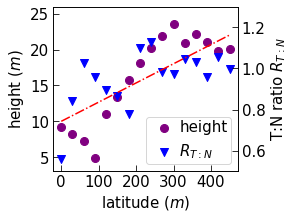

In [ ]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 15})

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax2.plot(l, m*l + b, color='red', linestyle='-.')

ax1.set_xlabel('latitude ($m$)')
ax1.set_ylabel('height ($m$)')
s1 = ax1.scatter(l, h, color='purple', label='height', s=2**6)
ax1.tick_params(axis='y')
ax1.tick_params(direction="in", length=6)
ax1.set_ylim(h_N,h_M)
ax1.set_yticks(range(5,26,5))
ax1.set_xticks(range(0,401,100))

ax2.set_ylabel('T:N ratio $R_{T:N}$')  # we already handled the x-label with ax1
s2 = ax2.scatter(l, r, color='blue', label="$R_{T:N}$", s=2**6, marker="v")
ax2.tick_params(axis='y')
ax2.tick_params(direction="in", length=6)
ax2.set_ylim(r_N,r_M)
ax2.set_yticks(np.arange(0.6,1.3, 0.2))

ax1.legend([s1, s2], [s1.get_label(), s2.get_label()], loc='lower right', handletextpad=0, borderpad=0.2)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

set_size(fig, (4, 3), dpi=96*3)


plt.show()

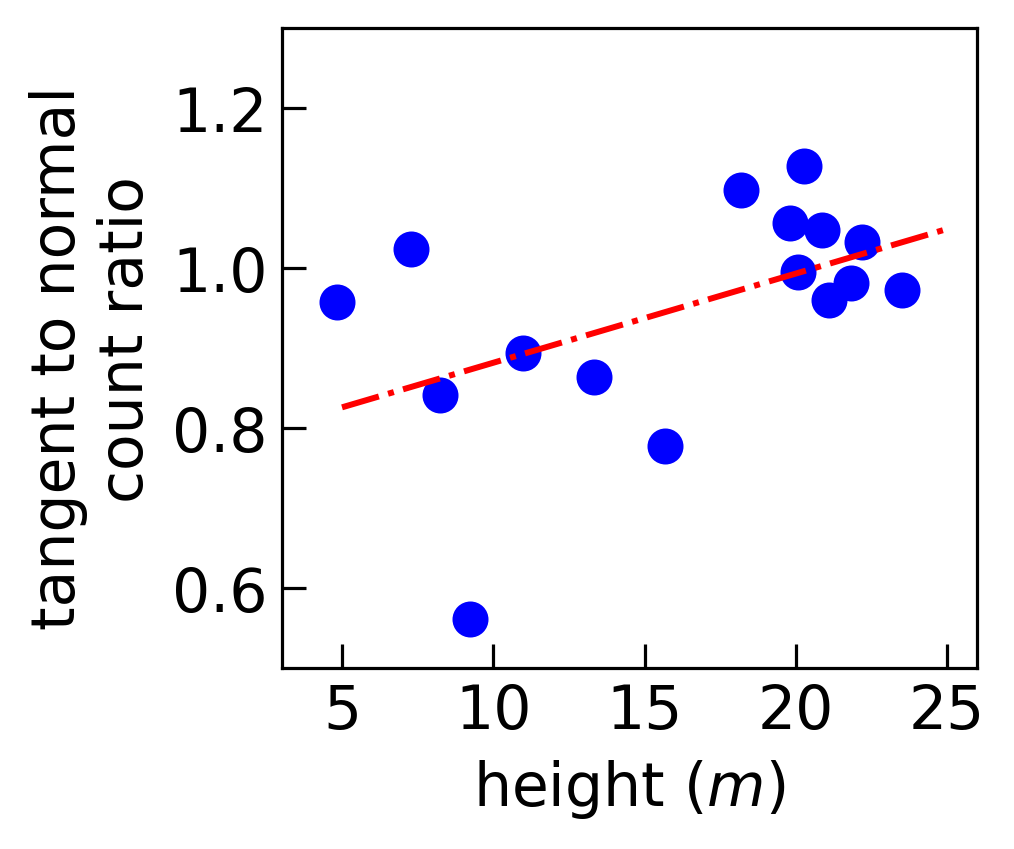

In [ ]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(figsize=(3.75, 3.20), dpi=96*3)
#plt.title('(d)')

plt.ylim(0.5, 1.3)
plt.xlim(3, 26)
plt.scatter(h, r, color='blue', label='height', s=2**6)
plt.yticks(np.arange(0.6, 1.25, 0.2))

m, b = np.polyfit(h, r, 1)
x = np.array((5, 25))
plt.plot(x, m*x + b, color='red', linestyle='-.')

plt.tick_params(axis='y')
plt.tick_params(direction="in", length=6)

plt.xticks(range(5,26,5))

plt.xlabel('height ($m$)')
plt.ylabel('tangent to normal \n count ratio')

fig.tight_layout()  # otherwise the right y-label is slightly clipped


plt.show()

## rock size below and above middle spline

In [ ]:
lower_half_shape = gpd.read_file("c3_rocks/filtered_v1/below_half_rocks.shp")
upper_half_shape = gpd.read_file("c3_rocks/filtered_v1/above_half_rocks_0.shp")

-7.728512787104254


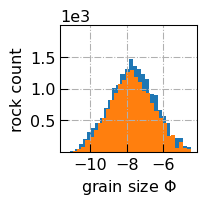

In [ ]:
areas = lower_half_shape.area
areas = areas[areas>0.000]
#areas = areas[areas>0.007853981633974483]
areas = areas.to_numpy()
areas = areas[areas>0]
D_mm = np.sqrt(areas * 10**6/pi)*2
phi = -np.log2(D_mm)
print(np.median(phi))

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 12})

size = (2.15, 2.15)
dpi = 96
fig = plt.figure(figsize = size, dpi=dpi)
plt.ylabel('rock count')
plt.xlabel('grain size $\Phi$')
plt.ylim(0, 2000)

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xticks(np.arange(-10, 1, 2.0))
plt.yticks(np.arange(500, 2000, 500))

plt.hist(Phi[Phi<5], bins=30)
plt.hist(phi[phi<5], bins=30)
plt.tick_params(direction="in", length=6)
plt.grid(linestyle='-.')

set_size(fig, size, dpi=dpi)
#plt.savefig('paper_figures/f6_0.svg', format='svg')
plt.show()

-7.6913003653061125


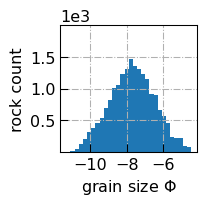

In [ ]:
areas = upper_half_shape.area
areas = areas[areas>0.000313]
#areas = areas[areas>0.007853981633974483]
areas = areas.to_numpy()
areas = areas[areas>0]
D_mm = np.sqrt(areas * 10**6/pi)*2
Phi = -np.log2(D_mm)
print(np.median(Phi))

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 12})

size = (2.15, 2.15)
dpi = 96
fig = plt.figure(figsize = size, dpi=dpi)
plt.ylabel('rock count')
plt.xlabel('grain size $\Phi$')
plt.ylim(0, 2000)

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xticks(np.arange(-10, 1, 2.0))
plt.yticks(np.arange(500, 2000, 500))
plt.hist(Phi[Phi<5], bins=30)
plt.tick_params(direction="in", length=6)
plt.grid(linestyle='-.')

set_size(fig, size, dpi=dpi)
#plt.savefig('paper_figures/f6_0.svg', format='svg')
plt.show()

In [ ]:
ratios = []

for i in range(nm_lat):
  if i not in shape_dict.keys():
    continue

  y0 = latitude0 + step*i
  y1 = latitude0 + step*i + step
  
  upper_part = upper_half_shape.cx[:, y0:y1]
  lower_part = lower_half_shape.cx[:, y0:y1]

  upper_area = upper_part.area
  areas = upper_area.to_numpy()
  D_mm = np.sqrt(areas * 10**6/pi)*2
  upper_phi = -np.log2(D_mm)

  lower_area = lower_part.area
  areas = lower_area.to_numpy()
  D_mm = np.sqrt(areas * 10**6/pi)*2
  lower_phi = -np.log2(D_mm)

  r = np.mean(upper_phi)/np.mean(lower_phi)
  ratios.append(r)



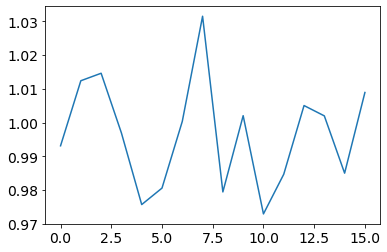

In [ ]:
plt.plot(range(16), ratios)
plt.show()

### tangent deviation histograms for rocks below the scarp middle line

In [ ]:
lower_half_shape = gpd.read_file("c3_rocks/filtered_v1/below_half_rocks.shp")
areas = lower_half_shape.area
lower_half_shape = lower_half_shape[areas>0.000314]

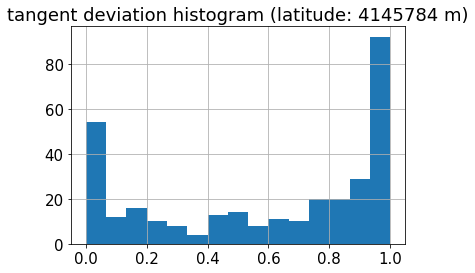

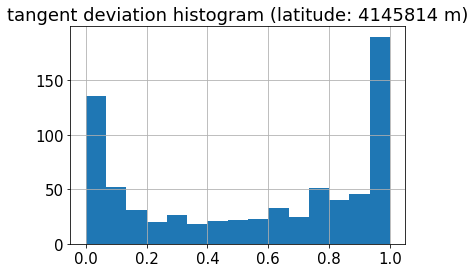

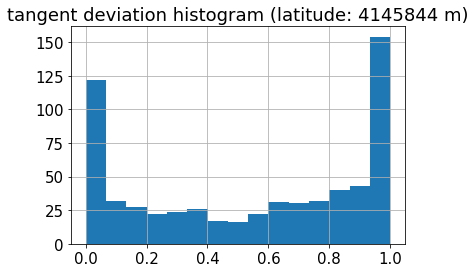

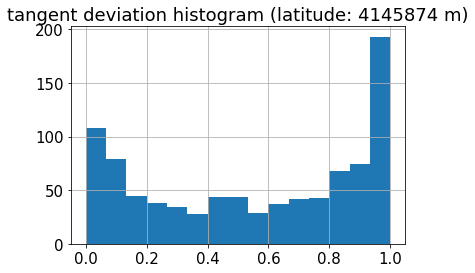

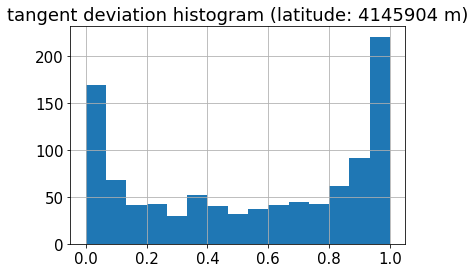

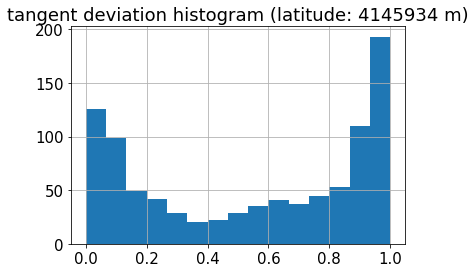

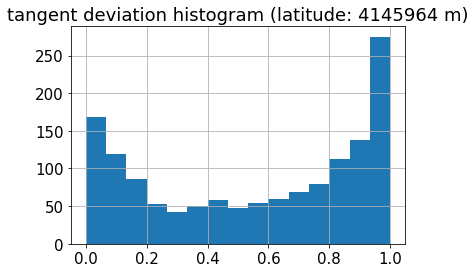

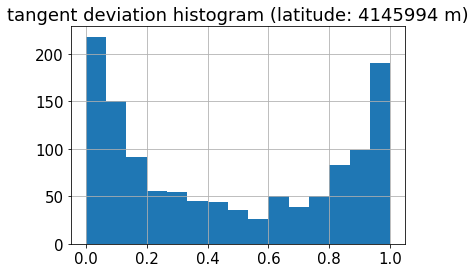

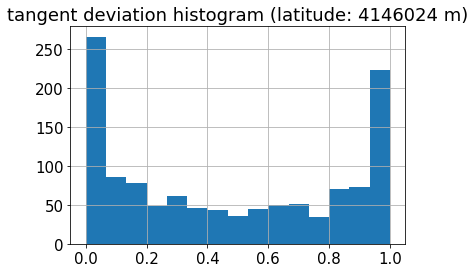

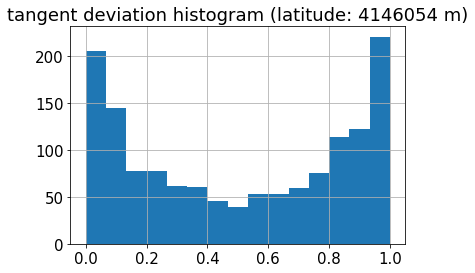

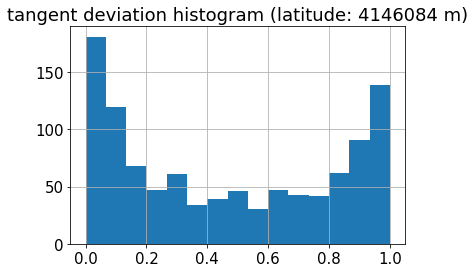

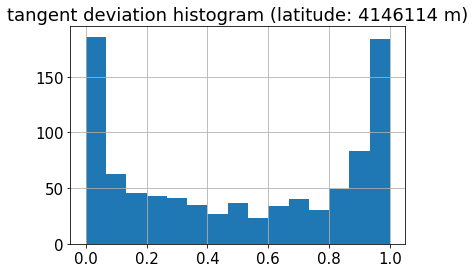

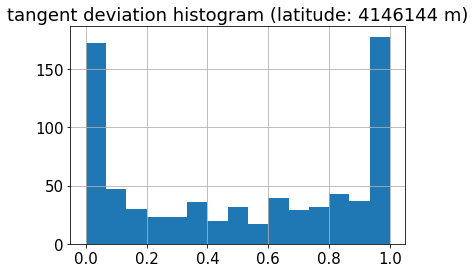

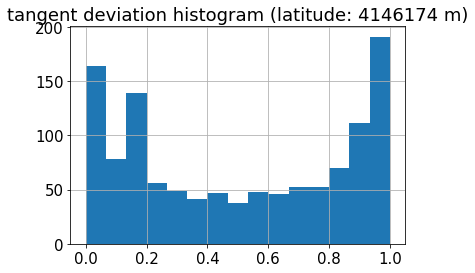

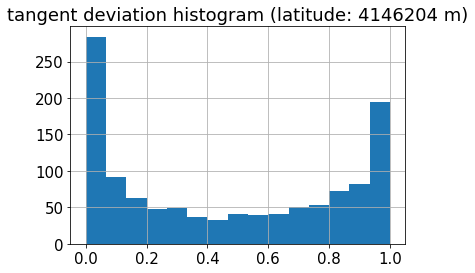

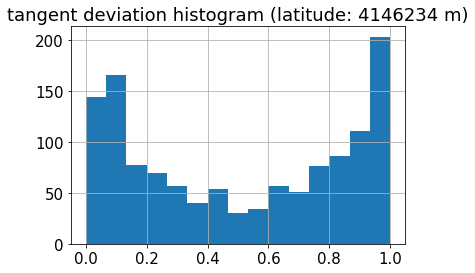

In [ ]:
# rocks below the middle line

# define a deviation function
def dev(angle, tan_angle):
  # y = [-cos(2*(x-tan_angle)) + 1] * 0.5
  # 0: close to tangent vector
  # 1: close to normal vector or perpendicular to tangent vector
  y = 0.5*(- np.cos(2*np.deg2rad(angle-tan_angle)) + 1)
  return y

deviations = []

for i in range(nm_lat):
  if i not in shape_dict.keys():
    continue

  tan_angle = tan_angles[i]
  y0 = latitude0 + step*i
  y1 = latitude0 + step*i + step
  
  box_sk_shape = sk_shape.cx[:, y0:y1]
  mean_x = box_sk_shape['geometry'].x.mean()
  
  #box_rock_shape = c3_rock_shape.cx[:mean_x, y0:y1]
  box_rock_shape = lower_half_shape.cx[:, y0:y1]

  angles = box_rock_shape['angle']
  devs = dev(angles, tan_angle)
  deviations.append(devs)
  devs.hist(bins=15)
  plt.title("tangent deviation histogram (latitude: {lat} m)".format(lat = int(y0)))
  plt.show()


In [ ]:
dev_all_below = []
for deviation in deviations:
  dev_nd = deviation.to_numpy().tolist()
  dev_all_below = dev_all_below + dev_nd

dev_all_below = np.asarray(dev_all_below)

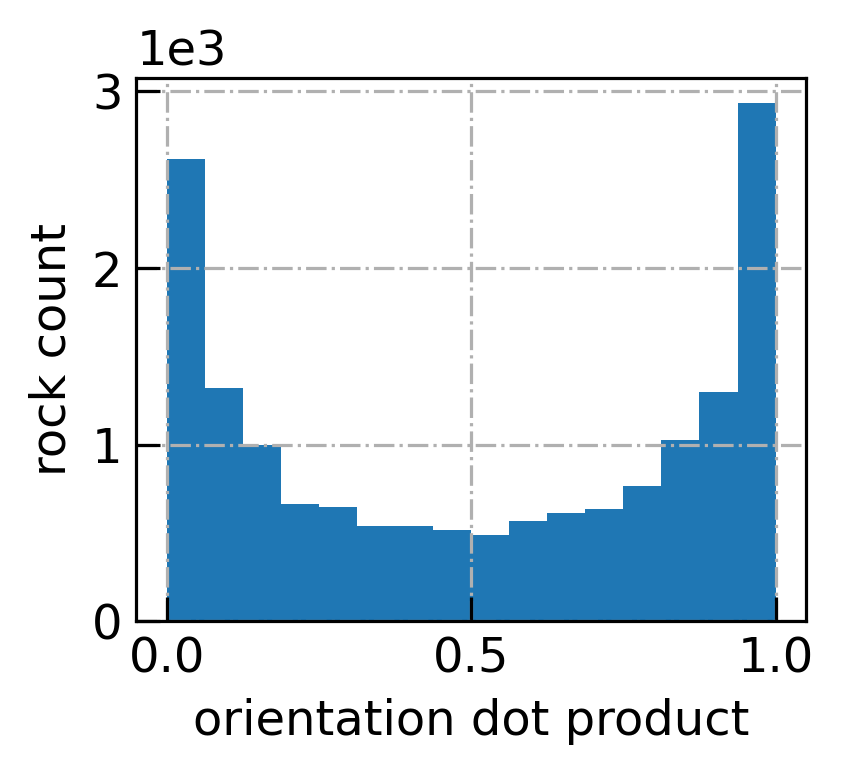

In [ ]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 12})

size = (3., 2.5)
dpi=96*3
plt.figure(figsize = size, dpi=dpi)
plt.hist(dev_all_below, bins = 16) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.grid(linestyle='-.')
plt.tick_params(direction="in", length=6)
#plt.title("tangent deviation histogram (entire fault scarp)") 
plt.xlabel("orientation dot product")
plt.ylabel("rock count")
#plt.title('western half \nscarp')
plt.show()

# tangent: normal ratio
It seems there are more tangent rocks as the fault scarp height increases.

In [ ]:
# define a deviation function
def dev(angle, tan_angle):
  # y = [-cos(2*(x-tan_angle)) + 1] * 0.5
  # 0: close to tangent vector
  # 1: close to normal vector or perpendicular to tangent vector
  y = 0.5*(- np.cos(2*np.deg2rad(angle-tan_angle)) + 1)
  return y

lat_height_t2n = []

for i in range(nm_lat):
  if i not in shape_dict.keys():
    continue

  y = latitude0 + step*i + step/2.
  idx = np.argmin(np.abs(lats - y))
  #print(np.abs(lats - y))
  #print(np.abs(lats - y)[idx])
  #print(idx)
  height = height_pts[idx, 2]

  tan_angle = tan_angles[i]
  y0 = latitude0 + step*i
  y1 = latitude0 + step*i + step
  
  box_sk_shape = sk_shape.cx[:, y0:y1]
  mean_x = box_sk_shape['geometry'].x.mean()
  
  box_rock_shape = c3_rock_shape.cx[:mean_x, y0:y1]  # rocks below the middle line
  #box_rock_shape = c3_rock_shape.cx[:, y0:y1]  # all rocks on the entire area

  angles = box_rock_shape['angle']
  devs = dev(angles, tan_angle)
  
  
  tangent_nm = devs[devs < 0.5].index.shape[0]
  normal_nm = devs[devs > 0.5].index.shape[0]
  t2n = float(tangent_nm) / normal_nm
  lat_height_t2n.append((y, height, t2n))

lat_height_t2n = np.asarray(lat_height_t2n)

In [ ]:
l = lat_height_t2n[:, 0] - lat_height_t2n[:, 0][0]

r = lat_height_t2n[:, 2]
r_M = 1.3
r_N = 0.5

h = lat_height_t2n[:, 1]
h_M = 26
h_N = 3

h_in_r = (h - h_N) / (h_M - h_N) * (r_M - r_N) + r_N

y = np.concatenate((r, h_in_r))
x = np.concatenate((l, l))

m, b = np.polyfit(x, y, 1)

In [ ]:
a, d = np.polyfit(h, r, 1)
cor, p = pearsonr(lat_height_t2n[:, 2], lat_height_t2n[:, 1])
print("The correlation is ", cor)
print("The p-value is ", "{:.3e}".format(p))
print(r2_score(r, a*h + d))
print(cor**2)

The correlation is  0.6768705181264698
The p-value is  3.978e-03
0.4581536983087956
0.4581536983087957


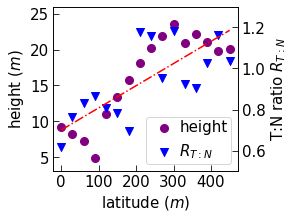

In [ ]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 15})

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax2.plot(l, m*l + b, color='red', linestyle='-.')

ax1.set_xlabel('latitude ($m$)')
ax1.set_ylabel('height ($m$)')
s1 = ax1.scatter(l, h, color='purple', label='height', s=2**6)
ax1.tick_params(axis='y')
ax1.tick_params(direction="in", length=6)
ax1.set_ylim(h_N,h_M)
ax1.set_yticks(range(5,26,5))
ax1.set_xticks(range(0,401,100))

ax2.set_ylabel('T:N ratio $R_{T:N}$')  # we already handled the x-label with ax1
s2 = ax2.scatter(l, r, color='blue', label="$R_{T:N}$", s=2**6, marker="v")
ax2.tick_params(axis='y')
ax2.tick_params(direction="in", length=6)
ax2.set_ylim(r_N,r_M)
ax2.set_yticks(np.arange(0.6,1.3, 0.2))

ax1.legend([s1, s2], [s1.get_label(), s2.get_label()], loc='lower right', handletextpad=0, borderpad=0.2)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

set_size(fig, (4, 3), dpi=96*3)


plt.show()

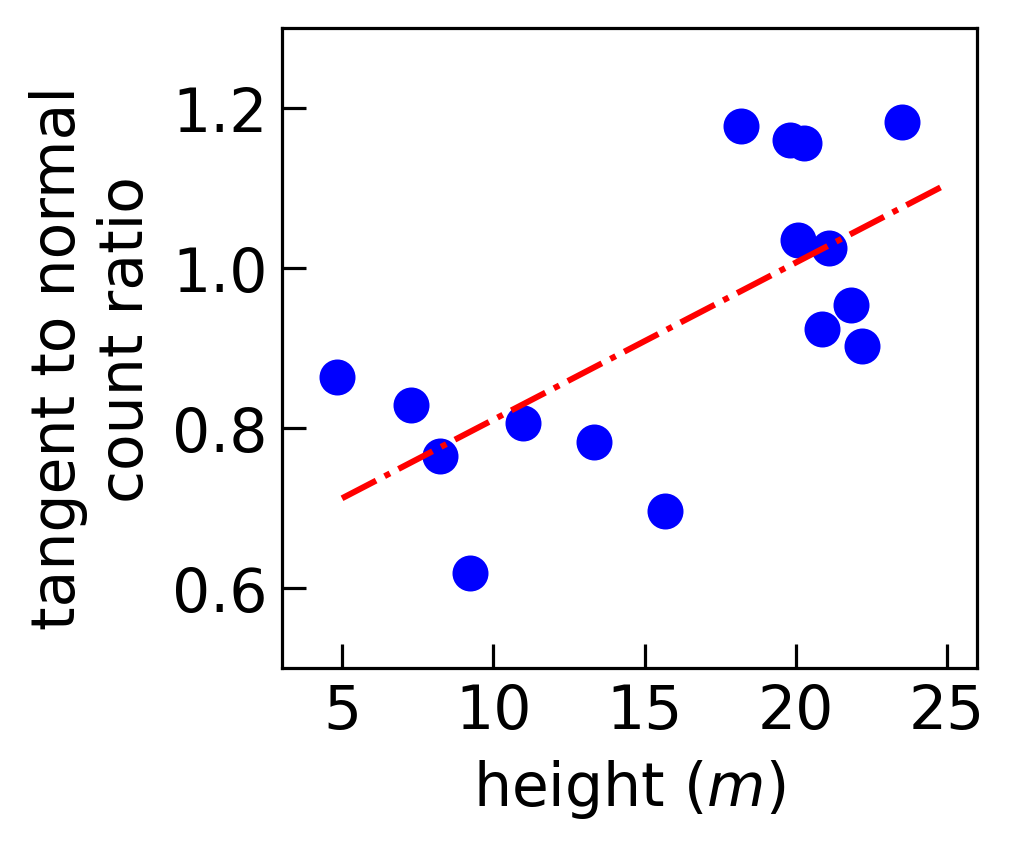

In [ ]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(figsize=(3.75, 3.2), dpi=96*3)
#plt.title('(d)')

plt.ylim(0.5, 1.3)
plt.xlim(3, 26)
plt.scatter(h, r, color='blue', label='height', s=2**6)
plt.yticks(np.arange(0.6, 1.25, 0.2))

m, b = np.polyfit(h, r, 1)
x = np.array((5, 25))
plt.plot(x, m*x + b, color='red', linestyle='-.')

plt.tick_params(axis='y')
plt.tick_params(direction="in", length=6)

plt.xticks(range(5,26,5))

plt.xlabel('height ($m$)')
plt.ylabel('tangent to normal \n count ratio')

fig.tight_layout()  # otherwise the right y-label is slightly clipped


plt.show()